## Analysis of Spike Data recorded In Vivo From a Place Cell In Rat Hippocampus

#### Aim: To come up with a suitable Generalized Linear Model that relates the spiking of the neuron to the rat's movement trajectory.

* Link to the data: https://github.com/Mark-Kramer/Case-Studies-Kramer-Eden/blob/master/Chapter9/Ch9-spikes-1.mat
* The case study data was part of an experiment in which a researcher implanted a small bundle of electrodes in a rat's hippocampus and trained the rat to perform a simple task of running back and forth along a linear maze. The data available is the observed spike train data and the position of the rat as a function of time, recorded during a few minutes of the experiment.

In [4]:
# Import modules
from scipy.io import loadmat
from pylab import *
rcParams['figure.figsize']=(12,3)



In [7]:
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF
from pandas import DataFrame as df

In [16]:
data = loadmat('spikes-1.mat')
who()

Name            Shape            Bytes            Type

t               177761           1422088          float64
X               177761           1422088          float64
spiketimes      220 x 1          1760             float64
spiketrain      177761           1422088          int64

Upper bound on total bytes  =       4268024


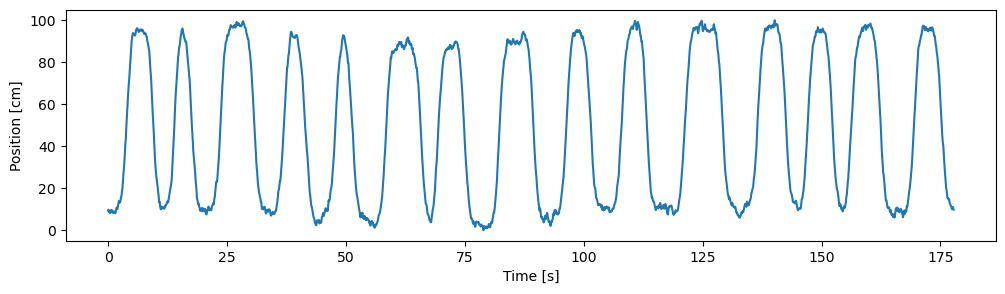

In [9]:
t = data['t'][:, 0]
X = data['X'][:, 0]
plot(t, X)
xlabel('Time [s]')
ylabel('Position [cm]')
show()

* About 15 passes during approximately 3 minutes were made by the rat when it run back and forth consistently

In [11]:
### Plotting the spikng activity in relation to the rat's movement trajectory
spiketimes = data["spiketimes"]
n_bins = len(t)

spiketrain = histogram(spiketimes,
                       bins = n_bins,
                       range = (t[0], t[-1])
                        )[0]

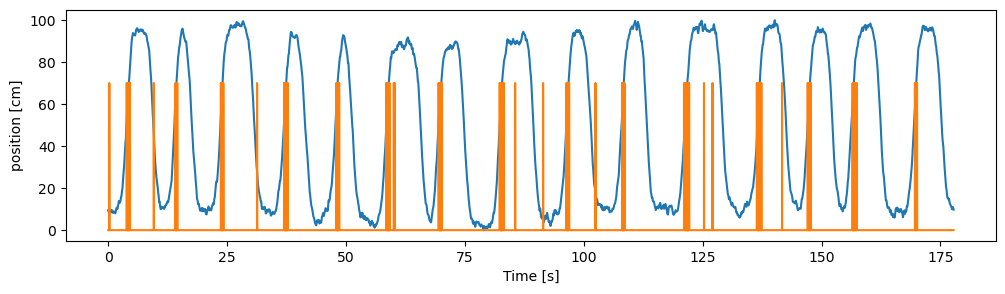

In [17]:
# Plotting the Position and the Spiketrain together
plot(t, X)
plot(t, 70 * spiketrain)
xlabel('Time [s]')
ylabel('position [cm]');


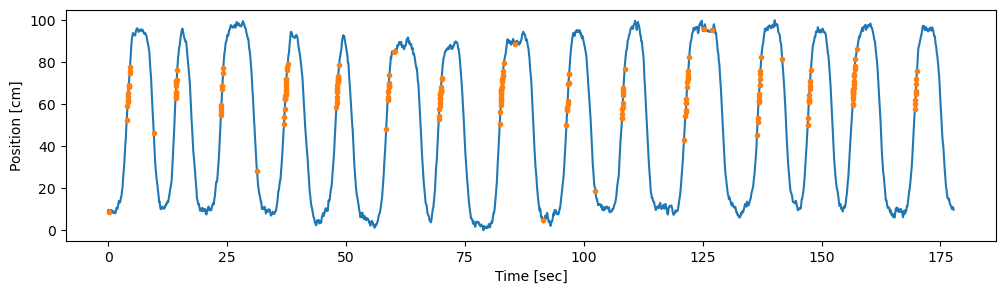

In [19]:
# Continuing the visualization with indices
spikeindex = where(spiketrain!=0)[0]
plot(t, X)
plot(t[spikeindex], X[spikeindex], '.')
xlabel('Time [sec]')
ylabel('Position [cm]');

* From the above plot, it is clear that the bulk of the spiking happens when the rat is running up the track. Same cannot be said about the rat running the track. Some sparse spikings happens during the runs back down the track.

### Computing an Occupancy Normalized Histogram:
To see how much firing relates to the time spent by the rat at the various positions.

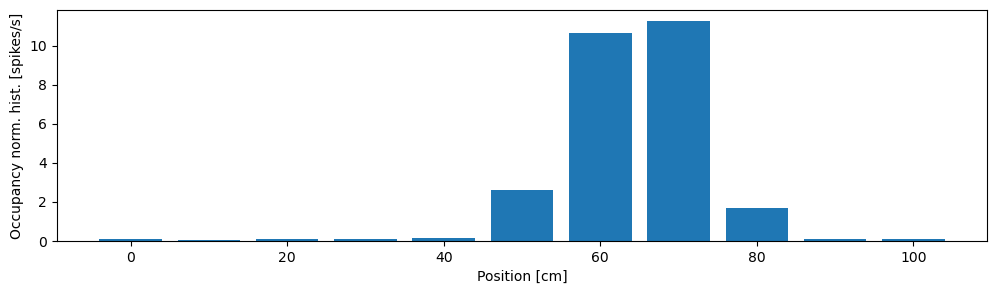

In [23]:
bin_edges = arange(-5, 106, 10)
spikehist = histogram(X[spikeindex], bin_edges)[0]
occupancy = histogram(X, bin_edges)[0]*0.001
bar(linspace(0,100,11), spikehist/occupancy, width=8)
xlabel('Position [cm]')
ylabel('Occupancy norm. hist. [spikes/s]');

* The Occupancy Normalized Histogram shows that the firing rate is highest around the 60 - 70 cm position and falls off rapidly as the rat moves away from that location. However the direction of movement is not accounted for in this visualization.

### Fitting a Point Process Model (Poisson GLM)

* The visualizations so far suggest that useful covariates for the model include the rat's position and its direction of motion.

In [26]:
# A dataframe of predictors that includes X and a constant term

predictors = df(data={'Intercept': ones_like(X), 'X': X})

# GLM model with Poisson family and identity link function
model1 = sm.GLM(spiketrain, predictors, family=Poisson(identity()))
model1_results = model1.fit()
b1 = model1_results.params
print('b1: ')
print(b1)

C:\Users\Benedict Andam\documents\bka\programming_projects\datascience\neuroengineering-project\env\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


b1: 
Intercept   -0.000097
X            0.000027
dtype: float64


* This model gives a negative firing rate and motivates changes to the model link function

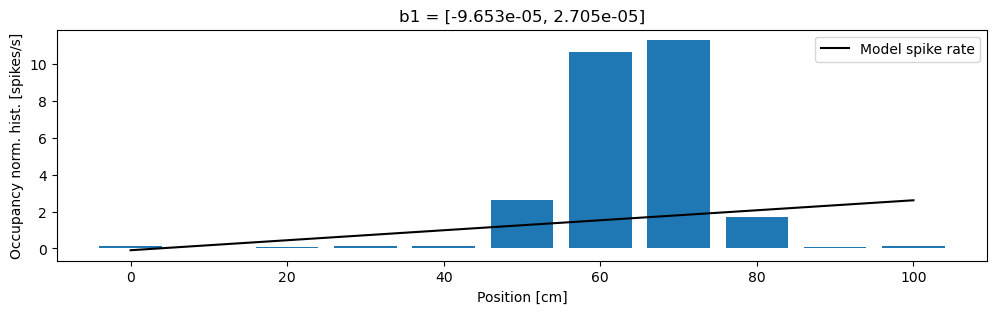

In [28]:
# Further visualize the quality of model1 by comparing the dependence it defines between position and spike rate to occupancy normalized histogram computed above
bins = linspace(0, 100, 11)
bar(bins, spikehist/occupancy, width = 8)
plot(bins, (b1[0]+b1[1]*bins)*1000, 'k',
     label="Model spike rate")
xlabel('Position [cm]')
ylabel('Occupancy norm. hist. [spikes/s]')
title("b1 = [{0[0]:.4}, {0[1]:.4}]". format(b1))
legend()
show()


* Some features are captured by this model; the fact that the spike rate increases as the rat moves from position x=0 toward position x=60. Nevertheless, much of the structure is missed by the model. The spike rate does not change linearly with position and begins to decrease as the rat's position increases beyond x=70.The form of the relation between position and firing rate is therefore wrong.

### Refining 1
Choosing a more appropriate link function for point process modelling. A function that is non-negative and is easy to fit; The log link.
This can also ensure that the liklihood has only one local maximum value which is the maximum likelihood estimate; from the concave likelihood of the data.

In [29]:
model2 = sm.GLM(spiketrain, predictors, family=Poisson(log()))
model2_results = model2.fit()
b2 = model2_results.params
print(b2)

Intercept   -7.438887
X            0.012943
dtype: float64


### Comparing Model to the Occupancy Normalized Histogram of the Data

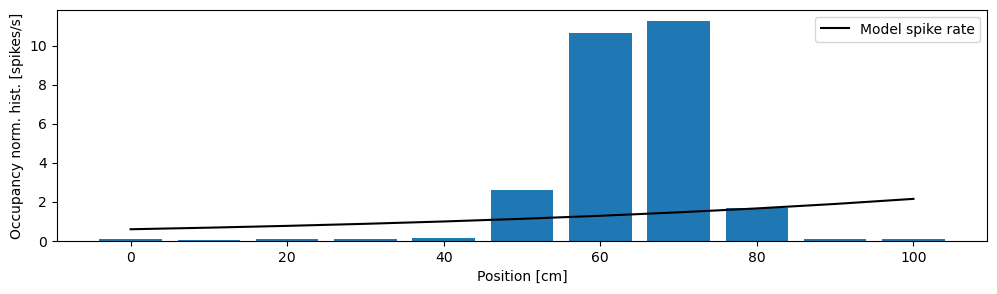

In [31]:
bar(bins, spikehist/occupancy, width=8)
plot(bins, exp(b2[0] + b2[1] * bins)* 1000, 'k',
     label='Model spike rate')
xlabel('Position [cm]')
ylabel('Occupancy norm. hist. [spikes/s]')
legend();

* Problem of negative rate of firing solved but the model still does not agree with the structure of the histogram. Maybe a nonlinear variable can be added to the model.


In [32]:
# Adding a square covariate to the model
predictors['X2'] = X**2

# fitting the GLM model with Poisson family and identity link function
model3 = sm.GLM(spiketrain, predictors, family=Poisson())
model3_results = model3.fit()
b3 = model3_results.params
print('b3:\n', b3)

b3:
 Intercept   -26.279057
X             0.690114
X2           -0.005463
dtype: float64


### Visualizing how model 3 does with the Occupancy Normalized Histogram

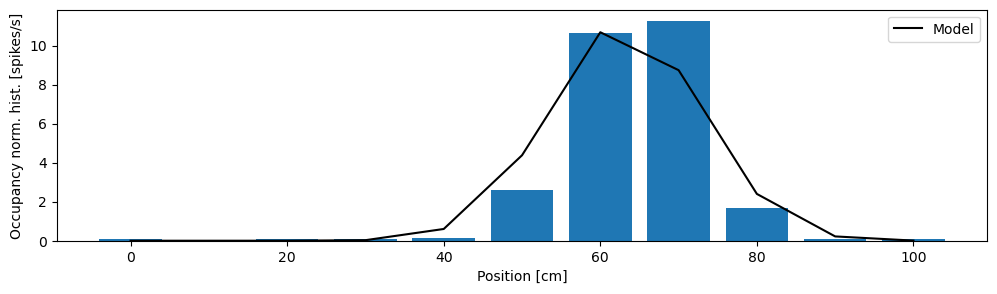

In [33]:
bar(bins, spikehist/occupancy, width=8)
plot(bins, exp(b3[0] + b3[1] * bins + b3[2] * bins**2) * 1000,
     'k', label='Model')
xlabel('Position [cm]')
ylabel('Occupancy norm. hist. [spikes/s]')
legend()
show()

It is seen from the figure above that Model 3 aligns much more closely with the occupancy normalized histogram. The firing rate is small at the beginning of the track, increases to a maximum firing rate near 10 Hz about 60 cm along the track, and then decreases as the position increases further. The firing rate model as a function of position looks like the bell-shaped or mound-shaped density that is often associated with the Gaussian (or normal) distribution. The fact that the firing rate is the exponential of a quadratic function of position means that the model can be rewritten in a form that more closely resembles the Gaussian function:

$$
   \lambda(t) = \alpha \exp\left(-\frac{(x - \mu)^2}{ 2\sigma^2}\right),
$$

where $\mu = −\beta_1/(2\beta_2)$ is the point along the track where the firing rate is maximal (the center of the place field), $\sigma^2 = −1/(2\beta_2)$ determines the range over which the firing rate is elevated (the size of the place field), and $\alpha = \exp(\beta_0−\beta_1^2/(4\beta_2))$ is the maximum firing rate at the place field center.

The fit method has given the maximum likelihood estimates for $\beta_0$, $\beta_1$, and $\beta_2$. From the principle of invariance or covariance,

$\hat{\mu} = −\hat{\beta_1}/(2\hat{\beta_2})$ is the maximum likelihood estimate of the place field center, $\hat{\sigma} = \sqrt{-1/(2\hat{\beta_2})}$ is the maximum likelihood estimate of the place field size.

Using these expressions to compute the maximum likelihood estimates:

In [35]:
mu = -b3[1] / (2 * b3[2])
sigma = sqrt(-1/(2 *b3[2]))
alpha = exp(b3[0] - b3[1]**2 / 4 / b3[2])

print('mu: {}\nsigma: {}\nalpha: {}'.format(mu, sigma, alpha))

mu: 63.162957804045966
sigma: 9.566890841873358
alpha: 0.011285495199169415


$\hat{\alpha}=0.011$ spikes/ms which is equivalent to a maximum firing rate of 11 spikes/s. The neuron spikes at a rate of about 11 spikes/s when the rat is 63cm along the track, but less than 2 spikes/s when the rat is more than 19cm away from that same position.

* The estimated Place Field Centre is about 63.2 cm down the track.
* The estimated Place Field Size of 9.6cm  means that the firing rate decreases about 40% when the rat is about 9.6cm from the place field centre, and decreases about 85% when the rat is about 19cm from the place field centre.

### Comparing and Evaluating models

* Using the Akaike's Information Criterion(AIC) to evaluate models 2 and 3

#### For model 2:


In [38]:
LL2 = model2.loglike(b2)
AIC2 = -2 * LL2 + 2 * 2
print('AIC2: ', AIC2)
print('model2_results.aic: ', model2_results.aic)

AIC2:  3344.790862938608
model2_results.aic:  3344.790862938608


#### For model 3:

In [39]:
LL3 = model3.loglike(b3)
AIC3 = -2 * LL3 + 2 * 3
print('AIC3: ', AIC3)

AIC3:  2708.776362292047


* Computing the difference between the AIC values/deviance:

In [41]:
dAIC = AIC2 - AIC3
print('dAIC: ', dAIC)

dAIC:  636.0145006465609


* A smaller AIC for model 3 suggests that model 3 is superior to model 2

#### Computing Confidence Intervals for Individual Model Parameters

* Using the bse attribute to compute 95% confidence intervals for the parameters of Model 2:

In [43]:
CI2 = array([b2 - 2 * model2_results.bse, b2 + 2 + model2_results.bse])
eCI2 = exp(CI2)
print('CI2: \n', CI2)
print('eCI2: \n', eCI2)

CI2: 
 [[-7.73444907  0.00892032]
 [-5.29110625  2.01495497]]
eCI2: 
 [[4.37493342e-04 1.00896023e+00]
 [5.03618589e-03 7.50038961e+00]]


The confidence interval for $\beta_0$ describes the uncertainty in the firing rate at position x = 0. At that position, it is 95% certain that the rate is between 0.0004 and 0.0008 (the left column of `eCI2`) spikes per millisecond, or between 0.4 and 0.8 spikes per second. The confidence interval for $\beta_1$ describes the uncertainty in the effect of a unit change in position on the firing rate. Each time $x$ is increased by 1, the rate gets modulated by a value between 1.009 and 1.0171 (the second column of `eCI2`). In other words, each centimeter increase in position increases the firing rate between about 0.9% and 1.7%.

* Determining the confidence intervals for each parameter in Model 3

In [44]:
CI3 = array([b3 - 2 * model3_results.bse,
              b3 + 2 * model3_results.bse])
print(CI3)

[[-2.99542831e+01  5.77810706e-01 -6.30948487e-03]
 [-2.26038307e+01  8.02417242e-01 -4.61644384e-03]]


* With the rightmost column being non-zero, the quadratic term is significant at the 95% confidence interval.

#### Residuals
* The Cumulative Raw Residual Process

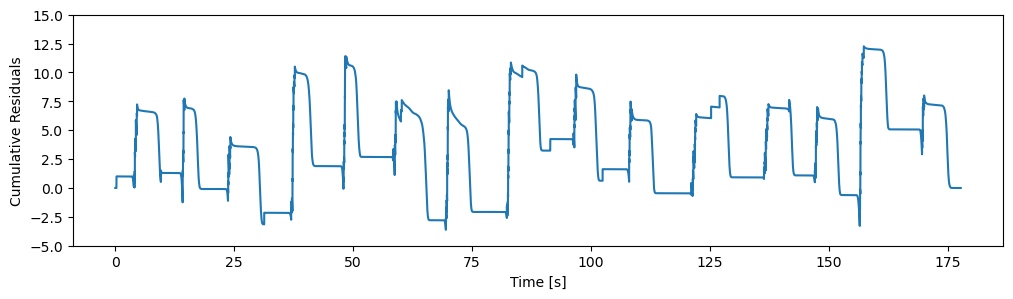

In [46]:
R = cumsum(model3_results.resid_response)
plot(t, R)
ylim(-5, 15)
xlabel('Time [s]')
ylabel('Cumulative Residuals');

* Suspicion: Direction is missing

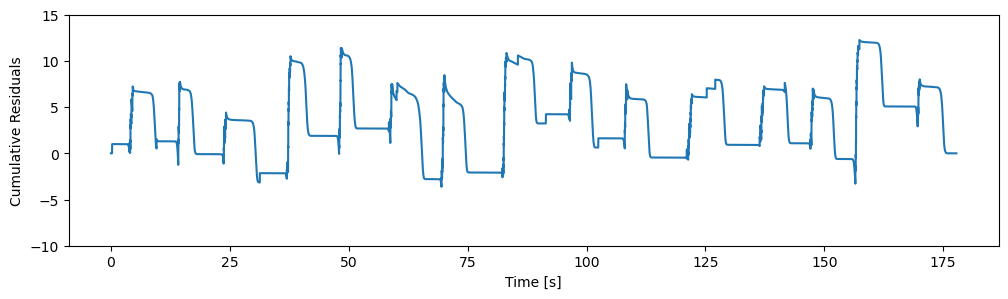

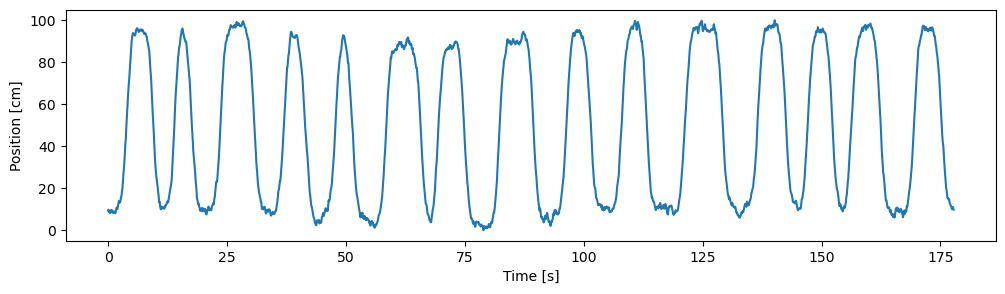

In [47]:
### Comparison of Cumulative residuals over time and rat position over time
plot(t, R)
ylim(-10, 15)
xlabel('Time [s]')
ylabel('Cumulative Residuals')
show()

plot(t, X)
xlabel('Time [s]')
ylabel('Position [cm]')
show()

* It is observed that the cumulative residual process increases whenever the rat is moving in the positive direction and decreases whenever the rat is moving in the negative direction. Hence, direction is missing from the model(model 3 - the best so far).

In [48]:
# Defining an indicator function for the direction of movement.
increasing = where(diff(X.flatten()) > 0)[0]
direction = zeros_like(X)
direction[increasing] = 1

In [49]:
# Add a direction variable as a fourth parameter
predictors['direction'] = direction

#GLM model
model4 = sm.GLM(spiketrain, predictors, family=Poisson())
model4_results = model4.fit()
b4 = model4_results.params
print(b4)

Intercept   -28.870275
X             0.688905
X2           -0.005452
direction     3.275282
dtype: float64


### Computing the cumulative residual process for the new model

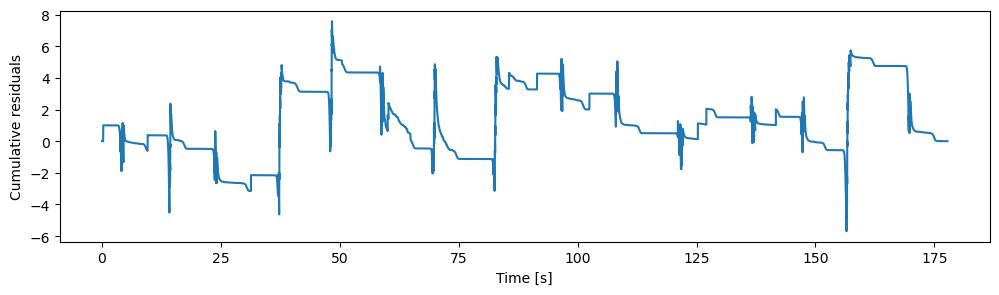

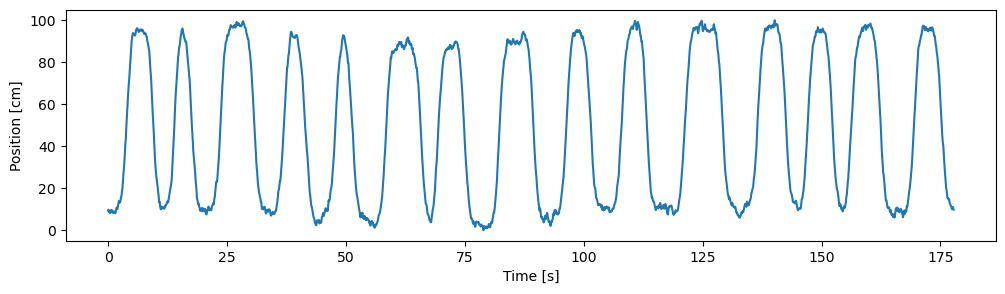

In [50]:
R = cumsum(model4_results.resid_response)
plot(t, R)
xlabel('Time [s]')
ylabel('Cumulative residuals')
show()

plot(t, X)
xlabel('Time [s]')
ylabel('Position [cm]')
show()

* The residual process has improved and is now centered at zero. The present structure as a function of time is no longer closely associated with the movement trajectory as it was for model 3.

* Estimating parameters for the center, width, and maximum firing rate of this place field:

In [51]:
# computing the maximum likelihood estimates 
mu = -b4[1] / (2 * b4[2])
sigma = sqrt(-1 / (2 * b4[2]))
alpha = exp(b4[0] - b4[1]**2 / (4 * b4[2]))

print('mu: ', mu)
print('sigma: ', sigma)
print('alpha: ', alpha)

mu:  63.18440082980761
sigma:  9.576905113790914
alpha:  0.0008199709288924612


* Visualizing the firing rate as a function of both position and direction: 

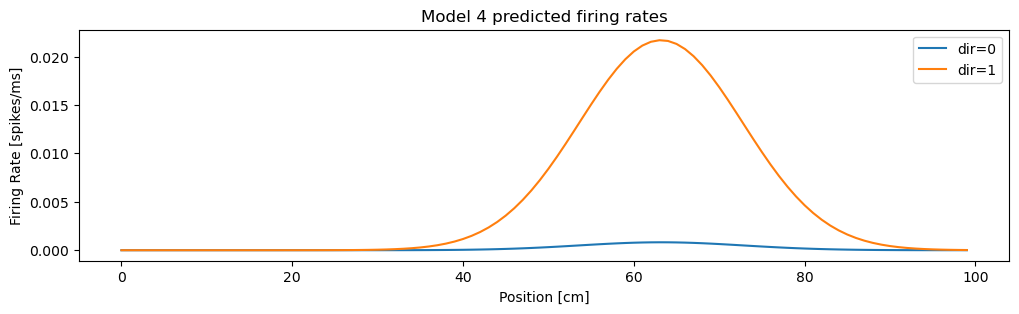

In [53]:
xs = arange(100)

# Create an array with [constant, position, position squared, direction] terms
dir_0 = array([ones_like(xs), xs, xs**2, zeros_like(xs)]).T
dir_1 = array([ones_like(xs), xs, xs**2, ones_like(xs)]).T
lambda_0 = model4_results.predict(dir_0)
lambda_1 = model4_results.predict(dir_1)

plot(xs, lambda_0, label = "dir=0")
plot(xs, lambda_1, label = "dir=1")
xlabel('Position [cm]')
ylabel('Firing Rate [spikes/ms]')
title('Model 4 predicted firing rates')
legend();